In [1]:
using Pkg
if isfile("../Project.toml") && isfile("../Manifest.toml")
    Pkg.activate(".")
end

# Init Bionic VTOL

In [2]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using TensorBoardLogger
using Logging

using JLD;
using BSON: @save, @load # save mode
using BSON

In [3]:
# TODO: set as desired
R_TOL = 0.5;
N_WAYPOINTS = 4; # including startpoint, >= 2
SLOW_MODE = true;
TRAINING = true;
EVALUATION = true;
VIDEO = false;

In [4]:
# number of steps
steps_slow = 80_000_000
steps_fast = 80_000_000
load_from_slow_step = 80_000_000 # TODO: choose slow model

save_freq = 100_000
validate_freq = 100_000

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

80000000

In [5]:
# crazyflie_param["gravity"] = 0.0; # debug

In [6]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


In [7]:
# TensorBoard
if TRAINING
    logger = TBLogger("tensorboard_SAC", tb_increment)
end

TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/tensorboard_SAC
	- open files    : 1


In [8]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [9]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [10]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    realtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds

    ###NEW###
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_position::Vector{T}

    slow_mode::Bool
    ######
end

In [11]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # 1 x
            typemin(T)..typemax(T), # 2 y
            typemin(T)..typemax(T), # 3 z

            typemin(T)..typemax(T), # 4  World Vector UP x
            typemin(T)..typemax(T), # 5  World Vector UP y
            typemin(T)..typemax(T), # 6  World Vector UP z

            typemin(T)..typemax(T), # 7  World Vector FRONT x
            typemin(T)..typemax(T), # 8  World Vector FRONT y
            typemin(T)..typemax(T), # 9  World Vector FRONT z
            
            typemin(T)..typemax(T), # 10 Body velocity along x
            typemin(T)..typemax(T), # 11 Body velocity along y
            typemin(T)..typemax(T), # 12 Body velocity along z
            
            typemin(T)..typemax(T), # 13 Body rotational velocity around x
            typemin(T)..typemax(T), # 14 Body rotational velocity around y
            typemin(T)..typemax(T), # 15 Body rotational velocity around z
            
            typemin(T)..typemax(T), # 16 position error along x (next gate - current position)
            typemin(T)..typemax(T), # 17 position error along y (next gate - current position)
            typemin(T)..typemax(T), # 18 position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # 19 way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # 20 way to next next gate y (next next gate - next gate)
            typemin(T)..typemax(T), # 21 way to next next gate z (next next gate - next gate)
            ], 
    )

    ###NEW###
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    ######
    
    if visualization
        create_Crazyflie(name, actuators = true);
        visualize_waypoints(waypoints[1:num_waypoints], 0.05)

        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)             
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space), 
        false, # episode done ?
        0.0, # time
        rng, # random number generator  

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt

        num_waypoints, # includig start point
        waypoints, 
        reached_goal,

        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode
        )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

# Define the RL interface

In [12]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [13]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [14]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
   
    norm_ω = norm(env.ω_B) # penalty for body rate

    if env.x_W[3] < 0
        fall = 1
    else
        fall = 0
    end
    
    if !env.slow_mode
        k_s /= env.norm_way
        k_p /= env.norm_way
    end
    
    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [15]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];


    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.05); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
        

   # TODO optional: add all rotation and delete position
    env.state = [env.x_W[1]; # 1 position along x
                 env.x_W[2]; # 2 position along y
                 env.x_W[3]; # 3 position along z

                 env.R_W[1,1];
                 env.R_W[2,1];
                 env.R_W[3,1];
        
                 env.R_W[1,3]; # 4  World Vector UP x
                 env.R_W[2,3]; # 5  World Vector UP y
                 env.R_W[3,3]; # 6  World Vector UP z

                 env.v_B[1]; #  10 Body velocity along x
                 env.v_B[2]; #  11 Body velocity along y
                 env.v_B[3]; #  12 Body velocity along z

                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]; #  15  Body rotational velocity around z

                 env.waypoints[2][1] - env.x_W[1]; # 16 position error to next gate along x
                 env.waypoints[2][2] - env.x_W[2]; # 17 position error to next gate along z
                 env.waypoints[2][3] - env.x_W[3]; # 18 position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # 19 way to next next gate x 
                 env.waypoints[3][2] - env.waypoints[2][2]; # 20 way to next next gate y
                 env.waypoints[3][3] - env.waypoints[2][3]]  # 21 way to next next gate z 
    

    env.t = 0.0; # time 0s
    
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized 

    env.done = false # reset termination

    env.projected_position = [0; 0; 0]
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        transform_arrow(string(env.name, "vel"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [16]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # call the step on the environoment with the next action 
    _step!(env, a)    
end

In [17]:
env = VtolEnv();

In [18]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[16]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [19]:
function scale_actions(next_action)
    return next_action*22_000.0 #debug
end

scale_actions (generic function with 1 method)

In [20]:
function _step!(env::VtolEnv, next_action)
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end


    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "vel"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.05, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end

    end
    
    
    env.state = [
                 env.x_W[1]; # 1 position along x
                 env.x_W[2]; # 2 position along y
                 env.x_W[3]; # 3 position along z

                 env.R_W[1,1];
                 env.R_W[2,1];
                 env.R_W[3,1];
        
                 env.R_W[1,3]; # 4  World Vector UP x
                 env.R_W[2,3]; # 5  World Vector UP y
                 env.R_W[3,3]; # 6  World Vector UP z

                 env.v_B[1]; #  10 Body velocity along x
                 env.v_B[2]; #  11 Body velocity along y
                 env.v_B[3]; #  12 Body velocity along z

                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]; #  15  Body rotational velocity around z

                 env.waypoints[env.current_point][1] - env.x_W[1]; # 16 position error to next gate along x
                 env.waypoints[env.current_point][2] - env.x_W[2]; # 17 position error to next gate along z
                 env.waypoints[env.current_point][3] - env.x_W[3]; # 18 position error to next gate along z
                 
                 0; # 19 way to next next gate x 
                 0; # 20 way to next next gate y
                 0] 
    
    if env.current_point <= env.num_waypoints
        env.state[19] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1]; # 16 way to next next gate x (next next gate - next gate), dummy integriert
        env.state[20] = env.waypoints[env.current_point + 1][2] - env.waypoints[env.current_point][2]; # 17 way to next next gate y (next next gate - next gate), dummy integriert
        env.state[21] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # 18 way to next next gate z (next next gate - next gate), dummy integriert
    end

    
    
    # Termination criteria
    env.done = 
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -1.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point 
        norm(env.x_W - env.projected_position) > 1.0 || # too far off the path 1 m 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [21]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.2s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.677578356806056e9, 1.677578359023864e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [22]:
seed = 123    
rng = StableRNG(seed)
UPDATE_FREQ = 1024

# define multiple environments for parallel training
env = VtolEnv(; rng = StableRNG(hash(seed)), name = "cf_SAC") 

# VtolEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[-Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf])`

## Action Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[0.0..1.0, 0.0..1.0, 0.0..1.0, 0.0..1.0])`

## Current State

```
[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.103591486005619, 4.003008630394852, 1.7647696667164254, -3.9530703802234872, -0.10251728638944968, -3.1952741277286876]
```


In [23]:
# Define the function approximator
# TODO ?
    ns, na = length(state(env)), length(action_space(env))

create_policy_net() = NeuralNetworkApproximator(
        model = GaussianNetwork(
            pre = Chain(
                Dense(ns, 256, Flux.relu, init = glorot_uniform(rng)),
                Dense(256, 256, Flux.relu, init = glorot_uniform(rng)),
            ),
            μ = Chain(Dense(256, na, Flux.identity; init = glorot_uniform(rng))),
            logσ = Chain(Dense(256, na, Flux.identity; init = glorot_uniform(rng))),
        ),
        optimizer = ADAM(1e-2),
    )

create_q_net() = NeuralNetworkApproximator(
        model = Chain(
            Dense(ns + na, 256, Flux.relu; init = glorot_uniform(rng)),
            Dense(256, 256, Flux.relu; init = glorot_uniform(rng)),
            Dense(256, 1, Flux.identity; init = glorot_uniform(rng)),
        ),
        optimizer = ADAM(1e-2),
    )

create_q_net (generic function with 1 method)

In [24]:
dataset_size = 1_000_000
start_steps = 10_000 # puffer size
update_after = 1_000
#trajectory_num = dataset_size
#TODO ? 

1000

In [25]:
    agent = Agent( # A wrapper of an AbstractPolicy
     # TODO ?    
    
    policy = SACPolicy(
            policy = create_policy_net(),
            qnetwork1 = create_q_net(),
            qnetwork2 = create_q_net(),
            #target_qnetwork1 = create_q_net(),
            #target_qnetwork2 = create_q_net(),
            γ = 0.99f0,
            τ = 0.005f0,
            α = 0.2f0,
            batch_size = 256,
            start_steps = start_steps,
            start_policy = RandomPolicy(Space([0.0..1.0 for _ in 1:na]); rng = rng),
            update_after = update_after,
            update_freq = UPDATE_FREQ,
            automatic_entropy_tuning = true,
            lr_alpha = 0.003f0,
            action_dims = na,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = dataset_size + 1,
            state = Vector{Float32} => (ns,),
            action = Vector{Float32} => (na,),
        ),

    
    );

In [26]:
function saveModel(t, agent, env) 
    policy = cpu(agent.policy.policy)
    qnetwork1 = cpu(agent.policy.qnetwork1)
    qnetwork2 = cpu(agent.policy.qnetwork2)
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "cf_sac_$(t).bson")
    else
        f = joinpath("./RL_models_fast/", "cf_sac_$(t).bson")
    end;
    @save f policy qnetwork1 qnetwork2
    println("parameters at step $t saved to $f")
end

saveModel (generic function with 1 method)

In [27]:
function loadModel() 
    f = joinpath("./RL_models_slow/", "cf_sac_$(load_from_slow_step).bson")
        
    @load f policy qnetwork1 qnetwork2
    
    println("load model $f")
    return policy, qnetwork1, qnetwork2
end

loadModel (generic function with 1 method)

In [28]:
function validate_policy(t, agent, env)
    # for validation extract the policy from the agend
    run(agent.policy, test_env, StopAfterEpisode(1), 
        ComposedHook(
        episode_test_step_hook, 
        episode_test_reward_hook
    ),
        )
    # the result of the hook
    reward = round((episode_test_reward_hook.rewards[end]),digits = 3)
    length = episode_test_step_hook.steps[end-1]
    
    println("step: ", t, " reward : ",reward, " length: ", length)

    with_logger(logger) do
        @info "evaluating" avg_length = length  avg_reward = reward  log_step_increment = 0;
    end
end;

episode_test_reward_hook = TotalRewardPerEpisode( is_display_on_exit=false)
episode_test_step_hook = StepsPerEpisode()
# create a env only for reward test

test_env = VtolEnv(;name = "test_cf", visualization = true, realtime = true);

In [29]:
# Define hook which is called during the training
total_reward_per_episode = TotalRewardPerEpisode(is_display_on_exit = false)
hook = ComposedHook(
    total_reward_per_episode,
    DoEveryNStep(saveModel, n=save_freq),
    DoEveryNStep(validate_policy, n=validate_freq),

    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            if length(total_reward_per_episode.rewards) > 0
                @info "training" total_reward_per_episode.rewards[end];
            end
        end
    end;
);

In [30]:
#todo load model
if !SLOW_MODE
    agent.policy.policy, agent.policy.qnetwork1, agent.policy.qnetwork2 = loadModel(); # todo 
end;

In [ ]:
if TRAINING
    ReinforcementLearning.run(
        agent,
        env,
        StopAfterStep(steps),
        hook
    )
end

Progress:   0%|                                         |  ETA: 1 days, 0:00:50m

parameters at step 100000 saved to ./RL_models_slow/cf_sac_100000.bson
step: 100000 reward : 1.973 length: 19


Progress:   0%|▏                                        |  ETA: 14:33:5725

parameters at step 200000 saved to ./RL_models_slow/cf_sac_200000.bson
step: 200000 reward : 2.103 length: 19


Progress:   0%|▏                                        |  ETA: 11:14:26

parameters at step 300000 saved to ./RL_models_slow/cf_sac_300000.bson
step: 300000 reward : 1.972 length: 19


Progress:   0%|▎                                        |  ETA: 9:31:17m

parameters at step 400000 saved to ./RL_models_slow/cf_sac_400000.bson
step: 400000 reward : 1.942 length: 19


Progress:   1%|▎                                        |  ETA: 8:36:35

parameters at step 500000 saved to ./RL_models_slow/cf_sac_500000.bson
step: 500000 reward : 1.972 length: 19


Progress:   1%|▎                                        |  ETA: 7:58:08

parameters at step 600000 saved to ./RL_models_slow/cf_sac_600000.bson
step: 600000 reward : Inf length: 19


Progress:   1%|▍                                        |  ETA: 7:32:08

parameters at step 700000 saved to ./RL_models_slow/cf_sac_700000.bson
step: 700000 reward : 2.038 length: 19


Progress:   1%|▍                                        |  ETA: 7:13:44

parameters at step 800000 saved to ./RL_models_slow/cf_sac_800000.bson
step: 800000 reward : 3.829 length: 21


Progress:   1%|▌                                        |  ETA: 6:59:11

parameters at step 900000 saved to ./RL_models_slow/cf_sac_900000.bson
step: 900000 reward : 2.556 length: 19


Progress:   1%|▌                                        |  ETA: 6:47:30

parameters at step 1000000 saved to ./RL_models_slow/cf_sac_1000000.bson
step: 1000000 reward : 1.957 length: 19


Progress:   1%|▋                                        |  ETA: 6:36:27

parameters at step 1100000 saved to ./RL_models_slow/cf_sac_1100000.bson
step: 1100000 reward : 3.459 length: 20


Progress:   1%|▋                                        |  ETA: 6:28:21

parameters at step 1200000 saved to ./RL_models_slow/cf_sac_1200000.bson
step: 1200000 reward : 1.961 length: 19


Progress:   2%|▋                                        |  ETA: 6:20:47

parameters at step 1300000 saved to ./RL_models_slow/cf_sac_1300000.bson



Progress:   2%|▋                                        |  ETA: 6:20:58

step: 1300000 reward : 1.928 length: 19


Progress:   2%|▊                                        |  ETA: 6:13:53

parameters at step 1400000 saved to ./RL_models_slow/cf_sac_1400000.bson
step: 1400000 reward : 1.92 length: 19


Progress:   2%|▊                                        |  ETA: 6:07:53

parameters at step 1500000 saved to ./RL_models_slow/cf_sac_1500000.bson
step: 1500000 reward : 3.812 length: 21


Progress:   2%|▉                                        |  ETA: 6:02:53

parameters at step 1600000 saved to ./RL_models_slow/cf_sac_1600000.bson
step: 1600000 reward : 1.94 length: 18


Progress:   2%|▉                                        |  ETA: 5:58:07

parameters at step 1700000 saved to ./RL_models_slow/cf_sac_1700000.bson
step: 1700000 reward : 1.952 length: 19


Progress:   2%|▉                                        |  ETA: 5:53:59

parameters at step 1800000 saved to ./RL_models_slow/cf_sac_1800000.bson
step: 1800000 reward : Inf length: 19


Progress:   2%|█                                        |  ETA: 5:49:48

parameters at step 1900000 saved to ./RL_models_slow/cf_sac_1900000.bson
step: 1900000 reward : 1.984 length: 19


Progress:   2%|█                                        |  ETA: 5:45:59

parameters at step 2000000 saved to ./RL_models_slow/cf_sac_2000000.bson
step: 2000000 reward : Inf length: 19


Progress:   3%|█▏                                       |  ETA: 5:42:35

parameters at step 2100000 saved to ./RL_models_slow/cf_sac_2100000.bson



Progress:   3%|█▏                                       |  ETA: 5:42:45

step: 2100000 reward : 1.917 length: 19


Progress:   3%|█▏                                       |  ETA: 5:39:15

parameters at step 2200000 saved to ./RL_models_slow/cf_sac_2200000.bson
step: 2200000 reward : 1.893 length: 18


Progress:   3%|█▏                                       |  ETA: 5:36:42

parameters at step 2300000 saved to ./RL_models_slow/cf_sac_2300000.bson
step: 2300000 reward : 4.303 length: 22


Progress:   3%|█▎                                       |  ETA: 5:36:41

parameters at step 2400000 saved to ./RL_models_slow/cf_sac_2400000.bson
step: 2400000 reward : 1.982 length: 19


Progress:   3%|█▎                                       |  ETA: 5:34:40

parameters at step 2500000 saved to ./RL_models_slow/cf_sac_2500000.bson
step: 2500000 reward : 1.997 length: 19


Progress:   3%|█▍                                       |  ETA: 5:32:02

parameters at step 2600000 saved to ./RL_models_slow/cf_sac_2600000.bson
step: 2600000 reward : 1.937 length: 19


Progress:   3%|█▍                                       |  ETA: 5:29:36

parameters at step 2700000 saved to ./RL_models_slow/cf_sac_2700000.bson
step: 2700000 reward : 27.781 length: 39


Progress:   3%|█▍                                       |  ETA: 5:28:06

parameters at step 2800000 saved to ./RL_models_slow/cf_sac_2800000.bson
step: 2800000 reward : 4.827 length: 24


Progress:   4%|█▌                                       |  ETA: 5:26:31

parameters at step 2900000 saved to ./RL_models_slow/cf_sac_2900000.bson
step: 2900000 reward : 80.162 length: 26


Progress:   4%|█▌                                       |  ETA: 5:25:02

parameters at step 3000000 saved to ./RL_models_slow/cf_sac_3000000.bson



Progress:   4%|█▌                                       |  ETA: 5:25:10

step: 3000000 reward : 1.935 length: 19


Progress:   4%|█▋                                       |  ETA: 5:23:32

parameters at step 3100000 saved to ./RL_models_slow/cf_sac_3100000.bson
step: 3100000 reward : 2.066 length: 19


Progress:   4%|█▋                                       |  ETA: 5:21:48

parameters at step 3200000 saved to ./RL_models_slow/cf_sac_3200000.bson
step: 3200000 reward : 6.354 length: 34


Progress:   4%|█▊                                       |  ETA: 5:20:37

parameters at step 3300000 saved to ./RL_models_slow/cf_sac_3300000.bson
step: 3300000 reward : 5.083 length: 25


Progress:   4%|█▊                                       |  ETA: 5:19:26

parameters at step 3400000 saved to ./RL_models_slow/cf_sac_3400000.bson
step: 3400000 reward : 2.004 length: 19


Progress:   4%|█▊                                       |  ETA: 5:18:04

parameters at step 3500000 saved to ./RL_models_slow/cf_sac_3500000.bson
step: 3500000 reward : 1.939 length: 19


Progress:   4%|█▉                                       |  ETA: 5:16:45

parameters at step 3600000 saved to ./RL_models_slow/cf_sac_3600000.bson
step: 3600000 reward : 3.39 length: 20


Progress:   5%|█▉                                       |  ETA: 5:15:33

parameters at step 3700000 saved to ./RL_models_slow/cf_sac_3700000.bson
step: 3700000 reward : 3.524 length: 20


Progress:   5%|██                                       |  ETA: 5:14:22

parameters at step 3800000 saved to ./RL_models_slow/cf_sac_3800000.bson
step: 3800000 reward : 1.968 length: 19


Progress:   5%|██                                       |  ETA: 5:13:23

parameters at step 3900000 saved to ./RL_models_slow/cf_sac_3900000.bson
step: 3900000 reward : 26.992 length: 44


Progress:   5%|██                                       |  ETA: 5:12:30

parameters at step 4000000 saved to ./RL_models_slow/cf_sac_4000000.bson
step: 4000000 reward : 2.29 length: 18


Progress:   5%|██▏                                      |  ETA: 5:11:24

parameters at step 4100000 saved to ./RL_models_slow/cf_sac_4100000.bson
step: 4100000 reward : 3.194 length: 19


Progress:   5%|██▏                                      |  ETA: 5:10:22

parameters at step 4200000 saved to ./RL_models_slow/cf_sac_4200000.bson
step: 4200000 reward : Inf length: 18


Progress:   5%|██▎                                      |  ETA: 5:09:22

parameters at step 4300000 saved to ./RL_models_slow/cf_sac_4300000.bson
step: 4300000 reward : 2.073 length: 18


Progress:   5%|██▎                                      |  ETA: 5:08:39

parameters at step 4400000 saved to ./RL_models_slow/cf_sac_4400000.bson
step: 4400000 reward : 3.943 length: 21


Progress:   6%|██▎                                      |  ETA: 5:07:52

parameters at step 4500000 saved to ./RL_models_slow/cf_sac_4500000.bson
step: 4500000 reward : 1.921 length: 18


Progress:   6%|██▍                                      |  ETA: 5:06:54

parameters at step 4600000 saved to ./RL_models_slow/cf_sac_4600000.bson
step: 4600000 reward : 1.955 length: 19


Progress:   6%|██▍                                      |  ETA: 5:06:13

parameters at step 4700000 saved to ./RL_models_slow/cf_sac_4700000.bson
step: 4700000 reward : 2.017 length: 19


Progress:   6%|██▌                                      |  ETA: 5:05:18

parameters at step 4800000 saved to ./RL_models_slow/cf_sac_4800000.bson
step: 4800000 reward : 2.058 length: 19


Progress:   6%|██▌                                      |  ETA: 5:04:32

parameters at step 4900000 saved to ./RL_models_slow/cf_sac_4900000.bson
step: 4900000 reward : 3.35 length: 19


Progress:   6%|██▌                                      |  ETA: 5:04:43

parameters at step 5000000 saved to ./RL_models_slow/cf_sac_5000000.bson
step: 5000000 reward : 3.442 length: 20


Progress:   6%|██▋                                      |  ETA: 5:04:42

In [ ]:
if TRAINING
    plot(episode_test_reward_hook.rewards)
end

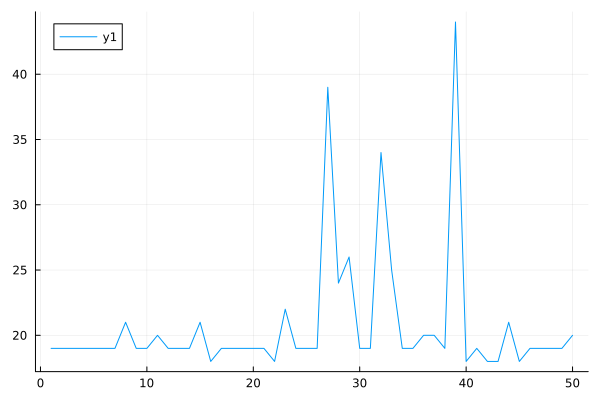

In [33]:
if TRAINING
    plot(episode_test_step_hook.steps[1:2:end])
end

In [34]:
close_visualization(); # closes the MeshCat visualization

# Evaluation

In [35]:
test_env = VtolEnv(;name = "test_cf");

In [36]:
function loadModel(path, num)
    f = joinpath(path, "cf_sac_$num.bson")
    
    policy = create_policy_net();
    qnetwork1 = create_q_net();
    qnetwork2 = create_q_net();
    
    #@load f policy qnetwork1 qnetwork2
    policy = BSON.load(f)[:policy]
    qnetwork1 = BSON.load(f)[:qnetwork1]
    qnetwork2 = BSON.load(f)[:qnetwork2]
    
    #println("load model $f")
    return policy, qnetwork1, qnetwork2
end;

In [37]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(is_display_on_exit=false)
    # create a env only for reward test
    for i in 1:num_models
          
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        sum_compl_time = 0;
        n_success = 0;
        
        for exp in 1:num_test
            if SLOW_MODE
                path = "./RL_models_slow/"
            else
                path = "./RL_models_fast/"
            end
            agent.policy.policy, agent.policy.qnetwork1, agent.policy.qnetwork2 = loadModel(path, i * save_freq); 
            RLBase.reset!(test_env)
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
                sum_compl_time += test_env.t
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
            avg_compl_time[i] = sum_compl_time / n_success;
        else
            avg_velocity[i] = NaN
            avg_compl_time[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        print("progress: $(percent)%   \r")
        flush(stdout)
        
    end
    
    
end;

In [38]:
if EVALUATION
    
    NUM_MODELS = Int(steps / save_freq);  
    NUM_TEST = 100; # TODO: change as desired 

    rewards = zeros(NUM_MODELS, 1);
    success_rate = zeros(NUM_MODELS, 1);
    avg_velocity = zeros(NUM_MODELS, 1);
    avg_compl_time = zeros(NUM_MODELS, 1);
    
    validate(NUM_MODELS, NUM_TEST);
    
end;

LoadError: InterruptException:

In [ ]:
if EVALUATION
    results_path = pwd() * "/plots/";
    if SLOW_MODE
        results_path = results_path * "slow/"
    else
        results_path = results_path * "fast/"
    end
    
    save(results_path * "iterations.jld", "data", [1:NUM_MODELS] * save_freq) 
    
    save(results_path * "avg_comp_time.jld", "data", avg_compl_time)
    
    save(results_path * "avg_velocity.jld", "data", avg_velocity)
    
    save(results_path * "reward.jld", "data", rewards) 
        
    save(results_path * "success_rate.jld", "data", success_rate)
end;

In [40]:
results_path = pwd() * "/plots/";
if SLOW_MODE
    results_path = results_path * "slow/"
else
    results_path = results_path * "fast/"
end

iterations = load(results_path * "iterations.jld")["data"];
avg_compl_time = load(results_path * "avg_comp_time.jld")["data"];
avg_velocity = load(results_path * "avg_velocity.jld")["data"];
rewards = load(results_path * "reward.jld")["data"];
success_rate = load(results_path * "success_rate.jld")["data"];

LoadError: InterruptException:

In [41]:
fig_path = pwd() * "/plots/";
if SLOW_MODE
    fig_path = fig_path * "slow/"
else
    fig_path = fig_path * "fast/"
end

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/plots/slow/"

In [42]:
plot(iterations, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

LoadError: UndefVarError: iterations not defined

In [43]:
savefig(fig_path * "reward.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/plots/slow/reward.svg"

In [44]:
plot(iterations, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific, ylims=(-0.05,1.05))


LoadError: UndefVarError: iterations not defined

In [45]:
savefig(fig_path * "success_rate.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/plots/slow/success_rate.svg"

In [46]:
plot(iterations, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

LoadError: UndefVarError: iterations not defined

In [47]:
savefig(fig_path * "avg_velocity.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/plots/slow/avg_velocity.svg"

In [48]:
plot(iterations, avg_compl_time, xlabel="Iterations", ylabel="Average Completion Time", legend = false, xformatter = :scientific)

LoadError: UndefVarError: iterations not defined

In [49]:
savefig(fig_path * "avg_comp_time.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_3D_quadcopter_SAC/plots/slow/avg_comp_time.svg"

# Create Videos

In [50]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


In [51]:
if VIDEO  
  # TODO: load_model as desired
    vid_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

    if SLOW_MODE
        path = "./RL_models_slow/"
        load_model = 30_000_000 # TODO: load model
        println("slow mode")
    else
        path = "./RL_models_fast/"
        load_model = 30_000_000 # TODO: load model
        println("fast mode")
    end
    agent.policy.policy, agent.policy.qnetwork1, agent.policy.qnetwork2 = loadModel(path,load_model); 
    
    for i in 1:10
        sleep(5)
        RLBase.reset!(vid_env)
        run(agent.policy, vid_env, StopAfterEpisode(1))
    end
end;

In [52]:
close_visualization();

done